# Stock Market Predictions

In [175]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

## Stock market data for DAL ariline company

Dataset from [ALPHA VANTAGE](https://www.alphavantage.co/) by Alpha Vantage API


In [177]:
api_key = my_key
ticker = 'DAL'
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)
file_to_save = 'stock_market_data-%s.csv'%ticker

In [178]:
file_to_save

'stock_market_data-DAL.csv'

In [179]:
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [180]:
df.tail()

,Unnamed: 0,Date,Low,High,Close,Open
3365,4,2007-05-09,19.63,20.20,19.79,19.75
3366,3,2007-05-08,19.30,20.00,19.63,20.00
3367,2,2007-05-07,20.20,21.29,20.36,21.20
3368,1,2007-05-04,20.70,21.35,20.98,21.05
3369,0,2007-05-03,20.55,21.95,20.72,21.75


In [181]:
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
0,3369,2020-09-18,32.575,34.0200,32.84,33.22
1,3368,2020-09-17,33.635,35.0700,33.96,33.97
2,3367,2020-09-16,33.190,34.9900,34.57,33.80
3,3366,2020-09-15,33.100,34.4781,33.51,33.20
4,3365,2020-09-14,32.010,32.9000,32.82,32.29


## EDA

In [182]:
# Data sort by date

# Sort DataFrame by date
df = df.sort_values('Date')
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
3369,0,2007-05-03,20.55,21.95,20.72,21.75
3368,1,2007-05-04,20.70,21.35,20.98,21.05
3367,2,2007-05-07,20.20,21.29,20.36,21.20
3366,3,2007-05-08,19.30,20.00,19.63,20.00
3365,4,2007-05-09,19.63,20.20,19.79,19.75


In [183]:
df.shape

(3370, 6)

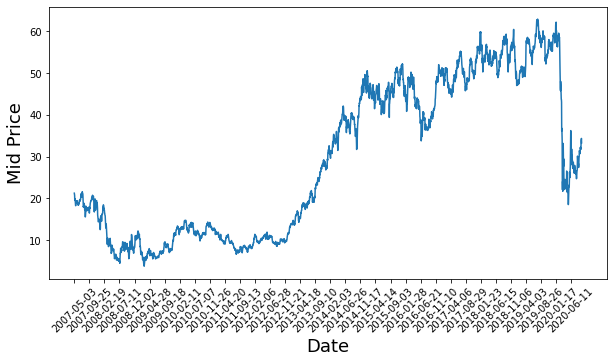

In [184]:
plt.figure(figsize = (10,5))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],100),df['Date'].loc[::100],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Splitting Data into a Training set and a Test set

In [185]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High']
low_prices = df.loc[:,'Low']
mid_prices = (high_prices+low_prices)/2.0

In [186]:
train_data = mid_prices[:3300].to_numpy()
test_data = mid_prices[3300:].to_numpy()

## Normalizing the Data
Define a scaler to normalize the data

In [187]:
# MinMaxScalar scales all the data to be in the region of 0 and 1.
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [188]:
### Choose a window size make sure it's not too small
# Train the Scaler with training data and smooth data
smoothing_window_size = 1500
for di in range(0,3000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [189]:
# Reshape the data back to the shape of [data_size]
# Reshape both train and test data
train_data = train_data.reshape(-1)

In [190]:
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

## Smooth the data using the exponential moving average. 
This helps to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve

In [191]:
# exponential moving average smoothing, only smooth training data
EMA = 0.0
gamma = 0.1
for ti in range(3300):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step Ahead Prediction via Averaging
Predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices.


### Standard Average
Prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N

In [192]:
window_size = 30
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00197


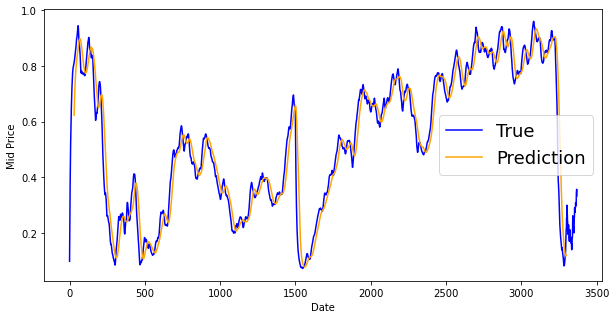

In [193]:
plt.figure(figsize = (10,5))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

### Exponential Moving Average

MSE error for EMA averaging: 0.00008


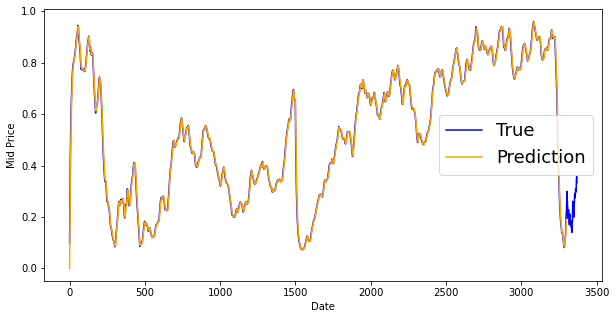

In [194]:
window_size = 30
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

plt.figure(figsize = (10,5))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Comment: Both model fit well with very low MSE. However, predicting the next day stock market value does not practically useful

For predict more than one step into the future:
    

## Recurrent neural networks (RNNs)
Keras LSTM, long short-term memory neural network,  model to forecast stock trends

In [195]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

data_set = df['Open'].values

In [196]:
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
3369,0,2007-05-03,20.55,21.95,20.72,21.75
3368,1,2007-05-04,20.70,21.35,20.98,21.05
3367,2,2007-05-07,20.20,21.29,20.36,21.20
3366,3,2007-05-08,19.30,20.00,19.63,20.00
3365,4,2007-05-09,19.63,20.20,19.79,19.75


In [197]:
data_set =df.iloc[:, 4:5].values

In [198]:
training_set=data_set[:3300]
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [199]:
X_train = []
y_train = []
for i in range(60, 3300):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [200]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=200,batch_size=64)

Epoch 1/200
3240/3240 [==============================] - 6s 2ms/step - loss: 0.0372
Epoch 2/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0053A: 0s - loss: 0.005
Epoch 3/200
3240/3240 [==============================] - ETA: 0s - loss: 0.004 - 5s 1ms/step - loss: 0.0047
Epoch 4/200
3240/3240 [==============================] - 5s 2ms/step - loss: 0.0044
Epoch 5/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0038
Epoch 6/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0041
Epoch 7/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0039
Epoch 8/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0034
Epoch 9/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0037
Epoch 10/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0033
Epoch 11/200
3240/3240 [==============================] - 5s 1ms/step - loss: 0.0035
Epoch 12/200
3240/3240 [=======

3240/3240 [==============================] - 5s 1ms/step - loss: 9.2529e-04
Epoch 187/200
3240/3240 [==============================] - 5s 2ms/step - loss: 9.4140e-04
Epoch 188/200
3240/3240 [==============================] - 5s 1ms/step - loss: 8.8105e-04
Epoch 189/200
3240/3240 [==============================] - 5s 1ms/step - loss: 8.6164e-04
Epoch 190/200
3240/3240 [==============================] - 5s 1ms/step - loss: 8.8793e-04
Epoch 191/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.5221e-04
Epoch 192/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.1884e-04
Epoch 193/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.1058e-04A: 0s - loss: 9.12
Epoch 194/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.3051e-04
Epoch 195/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.8490e-04
Epoch 196/200
3240/3240 [==============================] - 5s 1ms/step - loss: 9.4424e-04A: 0s -

In [203]:
# predict
test_set=data_set[3300:]
inputs = data_set[len(data_set) - len(test_set) - 60:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 130):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

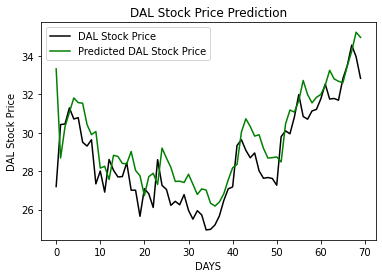

In [204]:
# Plot
plt.plot(data_set[3300:], color = 'black', label = 'DAL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DAL Stock Price')
plt.title('DAL Stock Price Prediction')
plt.xlabel('DAYS')
plt.ylabel('DAL Stock Price')
plt.legend()
plt.show()

#### Not bad